In [234]:
# !pip install fasttext
# !pip install contractions
# !pip install pyspellchecker
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install wordcloud
# !pip install scikit-learn
# !pip install scipy
# !pip install certifi
# !pip install pyenchant
# !pip install beautifulsoup4
# !pip install lxml
# !pip install tqdm
# !pip install catboost
# !pip install bayesian-optimization
# !pip install gensim
# !pip install tensorflow-hub
# !pip install transformers

In [235]:
# !wget -P resources/ 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
# !gdown "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA" -O "resources/dataset.zip"

In [236]:
!jupyter nbconvert --to script project_notebook.ipynb

[NbConvertApp] Converting notebook project_notebook.ipynb to script
[NbConvertApp] Writing 45041 bytes to project_notebook.py


## Imports

In [237]:
from __future__ import annotations
import pandas as pd
from pathlib import Path
import fasttext
import tensorflow as tf
from nltk.corpus import wordnet
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from keras.utils import to_categorical
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score
import keras
from nltk import PorterStemmer
from gensim.models import Word2Vec
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
from typing import List, Callable, Tuple, Any, Iterable
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from keras.layers import TextVectorization
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import os
from nltk.stem import WordNetLemmatizer
from keras import Sequential
from keras import layers
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bs4 import BeautifulSoup
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import enchant
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils.extmath import randomized_svd
from spellchecker import SpellChecker
import nltk
from wordcloud import WordCloud
import re
import numpy as np
import pickle
from numpy import diag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Constants

In [264]:
# OTHER
RESOURCES_FOLDER = 'resources'
FAST_TEXT_MODEL = f'{RESOURCES_FOLDER}/lid.176.bin'
RANDOM_STATE = 1234
MAX_SAMPLES_PER_CLASS = 200_000

# DATASET
DATASET_PATH = f'{RESOURCES_FOLDER}/dataset.csv'
ENCODING_TO_CLASS = {0: 'bad', 1: 'neutral', 2: 'good'}
PREPROCESSED_FOLDER = f'{RESOURCES_FOLDER}/preprocessed'
ONLY_ENGLISH = f'{PREPROCESSED_FOLDER}/only_english_dataset.csv'
PREPROCESSED_DATASET = f'{PREPROCESSED_FOLDER}/preprocessed_dataset.csv'
PREPROCESSED_DATASET_600K = f'{PREPROCESSED_FOLDER}/600k_preprocessed_dataset.csv'
DATASET_600K = f'{PREPROCESSED_FOLDER}/600k_dataset.csv'

# MODELS
MODELS_FOLDER = f'{RESOURCES_FOLDER}/models'
MAX_TOKENS = 30_000
BATCH_SIZE = 128
DEFAULT_EPOCHS = 100

# COMPUTED DATA
BINARY_DATA = f'{RESOURCES_FOLDER}/binary_data'

for folder in [PREPROCESSED_FOLDER, MODELS_FOLDER, BINARY_DATA]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## Utility functions

### Save and load

In [239]:
def save_numpy(array, file_path):
    os.makedirs(os.path.basename(file_path), exist_ok=True)
    np.save(file_path, array)

def load_numpy(file_path):
    return np.load(file_path)

def save_model_predictions(train_predictions, test_predictions, model_name):
    save_numpy(train_predictions, 
               f'{MODELS_FOLDER}/{model_name}/{model_name}_train_predictions.npy')
    save_numpy(test_predictions, 
               f'{MODELS_FOLDER}/{model_name}/{model_name}_test_predictions.npy')

def save_binary(file_path, obj):
    os.makedirs(Path(file_path).parent, exist_ok=True)
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def load_binary(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

    
def save_binary_model(model: Any, model_name: str):
    print(f'{MODELS_FOLDER}/{model_name}/{model_name}.bin')
    save_binary(f'{MODELS_FOLDER}/{model_name}/{model_name}.bin', model)
        
def save_csv(dataframe: pd.DataFrame, 
             path: str, 
             verbose: bool = True, 
             overwrite: bool = True):
    file_exists = os.path.exists(path)
    if not file_exists or (file_exists and overwrite):
        dataframe.to_csv(path, index=False)
        if verbose:
            print('file saved' if not file_exists else 'file overwrite')
    else:
        if verbose:
            print('file already exists')
        
def load_csv(path:str):
    return pd.read_csv(path)

def load_glove_embedding(file_path):
    def from_list_to_entry(line):
        return line[0], np.array(line[1:], dtype=np.float64)
    
    with open(file_path, 'r', encoding='utf-8') as f: 
        return dict([from_list_to_entry(line.split()) for line in f])

- `sample balanced`: takes at most `max_samples_per_class` from each class specified in `groupby_column`
- `compute_languages`: compute language for specified Series. It creates a new Series with `__label__[language]` for each text in the original Series

### DataFrame processing

In [240]:
def sample_balanced(dataframe: pd.DataFrame, 
                    max_samples_per_class: int, 
                    groupby_column: str, 
                    random_state: int = RANDOM_STATE):
  return dataframe.groupby(groupby_column)\
  .apply(lambda x: x.sample(max_samples_per_class, random_state=random_state))\
  .reset_index(drop=True)

def compute_languages(texts: pd.Series):
  model = fasttext.load_model(FAST_TEXT_MODEL)
  return texts.apply(lambda x: model.predict(x)[0][0])

def set_columns(columns: List[str]):
  def _set_columns(dataframe: pd.DataFrame):
    dataframe.columns = columns
    return dataframe
  return _set_columns

def drop_na():
  def _drop_na(dataframe: pd.DataFrame):
    return dataframe.dropna()
  return _drop_na

def remove_not_modal_languages(extracted_languages: pd.Series):
  def _remove_languages(dataframe: pd.DataFrame):
    modal_language = extracted_languages.value_counts().index[0]
    return dataframe[extracted_languages == modal_language].reset_index(drop=True)
  return _remove_languages

def compute_and_remove_not_modal_languages(text_column: str = 'text'):
  def _compute_and_remove(dataframe: pd.DataFrame):
    computed_languages = compute_languages(dataframe[text_column])
    return remove_not_modal_languages(computed_languages)(dataframe)
  return _compute_and_remove

def apply_preprocess(preprocess_functions: List[Callable]):
  def _apply_preprocess(dataframe: pd.DataFrame):
    for function in preprocess_functions:
      dataframe = function(dataframe)
    return dataframe
  return _apply_preprocess

def apply(series: pd.Series, mapping_function: Callable[[Any], Any]) -> List[Any]:
    return [mapping_function(value) for value in series.values]    

### Text processing

In [263]:
def to_lower(text: str):
  return text.lower()

def expand_contraction(word: str):
  return contractions.fix(word)

def lemmatize_text(split: bool = False):
    lemmatizer = WordNetLemmatizer()
    tag_to_pos = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV,
    }
    def _lemmatize_text(phrases: List[str] | List[List[str]]):
        if split:
            phrases = [phrase.split() for phrase in phrases]
        return [[lemmatizer.lemmatize(word, tag_to_pos.get(tag[0], wordnet.NOUN))
                 for word, tag in nltk.pos_tag(phrase)] 
                for phrase in phrases]
    return _lemmatize_text


def stem_text(split: bool = False):
    stemmer = PorterStemmer()
    def _stem_text(phrase: str | List[str]):
        if split:
            phrase = phrase.split()
        return [stemmer.stem(word) for word, _ in nltk.pos_tag(phrase)]
    return _stem_text
        

def stopwords_list(language='english'):
    return stopwords.words(language)

def is_stopword(language: str = 'english'):
  stopwords_set = stopwords_list(language)
  def _is_stopword(word: str):
    return word in stopwords_set
  return _is_stopword

def is_punctuation(word: str):
  return word in string.punctuation

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def correct_word(language: str = 'eng'):
  checker = SpellChecker(language)
  def _correct_words(word: str):
    return checker.correction(word)
  return _correct_words


def is_in_dictionary(language: str = "en_US"):
    dictionary = enchant.Dict(language)
    def _is_in_dictionary(word: str):
        return dictionary.check(word)
    return _is_in_dictionary

def tokenize(text: str):
  return word_tokenize(text)

def split(text: str):
    return text.split()

def remove_lxml():
    def _remove_lxml(text):
        return BeautifulSoup(text, 'lxml').get_text().strip()
    return _remove_lxml

def expand():
    def _expand(text):
        return contractions.fix(text)
    return _expand
    
def map_text(mapping_function):
    def _map_text(text):
        return mapping_function(text)
    return _map_text

def remove_links():
    link_regex = r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    def _remove_links(text):
        return re.sub(link_regex, "", text)
    return _remove_links
  
def remove_mails():
    mail_regex = r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'
    def _remove_mails(text):
        return re.sub(mail_regex, "", text)
    return _remove_mails      

def remove_stopwords():
    stopword_regex = r'\b(' + r'|'.join(stopwords_list()) + r')\b\s*'
    def _remove_stopwords(text):
        return re.sub(stopword_regex, '', text)
    return _remove_stopwords

def regex(pattern, repl):
    def _generic_regex(text):
        return re.sub(pattern, repl, text)
    return _generic_regex


def normalise(text):
    return re.compile(r"[^a-z0-1\s]").sub(r" ",re.compile(r"['\W']").sub(r" ",text.lower()))


class TextPreprocessor:
    _preprocess_functions = [
        map_text(lambda x: x.lower()),
        remove_links(), # remove links
        remove_mails(), # remove mails
        remove_lxml(),
        #expand(),
        regex('[^a-z]', ' '), # remove all non chars
        regex(r'\b(?:\w{1,2})\b', ' '), # remove two or one letters
        remove_stopwords(), # remove stopwords
        # lemmatize_text(),
        # stem_text(split=True),
        # map_text(lambda x: ' '.join(x))
        regex(r'\s+', ' ') # remove extra white spaces
    ]
    def __init__(self, verbose=True):
        self._verbose = verbose
        
    def preprocess(self, texts: Iterable[str]) -> List[str]:
        return [self._process_one_text(text) for text in tqdm(texts, 
                                                              disable= not self._verbose,
                                                              position=0, 
                                                              leave=True)]
    
    def _process_one_text(self, text: str) -> str:
        for function in self._preprocess_functions:
            text = function(text)
        return text 
  

### Dataset search

In [242]:
def search_in_text(dataset: pd.DataFrame, 
                   text: str | List[str], 
                   sentiment: int = None, 
                   limit: int = None):
    texts = [text] if isinstance(text, str) else text
    mask = pd.Series(True, index=dataset.index)
    for text in texts:
        mask &= dataset['text'].str.contains(text)
    if sentiment is not None:
        mask &= dataset['sentiment'] == sentiment
    return dataset[mask] if limit is None else dataset[mask].head(limit)

### Visualization

In [243]:
def print_texts(texts: List[str], highlight_texts: str | List = None):
    reset     = '\033[0m'
    red_color = '\033[91m'
    highlight_texts = [highlight_texts] if isinstance(highlight_texts, str) else highlight_texts
    if highlight_texts is not None:
        for highlight_text in highlight_texts:
            texts = [text.replace(highlight_text, red_color + highlight_text + reset) 
                     for text in texts]
    print('\n--------------------------------\n'.join(texts))
    
def plot_distribution(column: pd.Series, normalize: bool = True):
    sentiment_density = column.value_counts(normalize=normalize)
    plt.figure(figsize=(8, 6)) 
    plt.bar(sentiment_density.index, sentiment_density.values, color=['green', 'red', 'yellow'])
    plt.xlabel('Sentiment Types')
    plt.ylabel('Percentage')
    plt.title('Counts of Sentiments')
    plt.show()
  
def plot_singular_values(singular_values: List[float]):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(singular_values) + 1), y=singular_values, marker='o')
    plt.title('Singular Values')    
    plt.show()

def word_cloud(text: str, title: str = ""):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()
  
def plot_divisions(train, test, validation=None):
    print(f'train size: {len(train)}, test size: {len(test)}' + (f', validation size: {len(validation)}' if validation is not None else ''))
    total = len(train) + len(test) + (len(validation) if validation is not None else 0)
    sizes = {
        'train': len(train) / total * 100,
        'test': len(test) / total * 100
    }
    if validation is not None:
        sizes['validation'] = len(validation) / total * 100
        
    plt.figure(figsize=(8, 2))
    bottom = 0
    for label, percentage in sizes.items():
        plt.barh(
            [''],
            percentage,
            left=bottom,
            height= 0.35,
            label=f'{label} {int(percentage)}%',
        )
        bottom += percentage
    
    plt.xlabel('Percentage')
    plt.title('Dataset divisions')
    plt.legend()
    
    plt.xlim(0, 100)  # Set the x-axis limit to 0-100
    plt.tight_layout()
    plt.show()
    
def top_n(values, real, predicted_proba, best=True, n=5):
    predicted_proba_for_real = predicted_proba[np.arange(len(predicted_proba)), real]
    absolute_error = np.abs(real - predicted_proba_for_real)
    indices = np.argsort(absolute_error)
    top_n_indices = indices[:n] if best else indices[-n:][::-1]

    zipped_values = zip(values.values[top_n_indices], 
                        real.values[top_n_indices], 
                        predicted_proba_for_real[top_n_indices])
    
    for  value, real_class, percentage in zipped_values:
        print(value)
        print(f'class: {ENCODING_TO_CLASS[real_class]} predicted with {percentage * 100}%')
        print('=============================================')

def show_model_scores(train_pred, y_train, test_pred, y_test, model_name):
    class_labels = [ENCODING_TO_CLASS[key] for key in sorted(ENCODING_TO_CLASS.keys())]
    train_score = accuracy_score(train_pred.argmax(axis=1), y_train)
    test_score = accuracy_score(test_pred.argmax(axis=1), y_test)
    print(f"Scores for model train score is {train_score}, test score is {test_score}")
    # cm = confusion_matrix(y_test, test_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, 
    #             annot=True, 
    #             cmap='Blues', 
    #             fmt='d', 
    #             xticklabels=class_labels, 
    #             yticklabels=class_labels)
    # plt.title(f'Confusion matrix for model {model_name}')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()
    
def plot_history(history):
    # Extract training metrics from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    _, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracy, label='Train Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

### Model training

In [244]:
from sklearn.model_selection import GridSearchCV

import winsound

def ping():
    winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)

def split_continuously(*datas, partitions):
    partitions = np.atleast_1d(partitions)
    split_data = []
    for data in datas:
        initial_size = len(data)
        for p in partitions:
            size = int(initial_size * p)
            split_data.append(data[:size])
            data = data[size:]
    return tuple(split_data)

def bayes_grid_search(model_class: Any,
                      param_space: dict,
                      x: Any,
                      y: Any,
                      cv:int = 3,
                      scoring:str = 'accuracy',
                      fit_params: dict = None,
                      random_state:int = RANDOM_STATE,
                      fixed_params: dict = None,
                      init_points:int = 2,
                      n_iter: int = 10):
        
    def serialize_list():
        mapped_params = set()
        converted_space = param_space.copy()
        for param, values in param_space.items():
            if isinstance(values, List):
                mapped_params.add(param)
                converted_space[param] = (0, len(values) - 1)
        return converted_space, mapped_params
    

    converted_space, mapped_params = serialize_list()
    int_params = {param for param, values in converted_space.items()
                if all([isinstance(value, int) for value in values])}
    
    def back_categorical(params):
        reverted_space = params.copy()
        for hyperparameter in mapped_params:
            reverted_space[hyperparameter] = param_space[hyperparameter][params[hyperparameter]]
        return reverted_space
    
    def build_model_params(**params):
        discrete_params = {parameter: int(value) 
                           if parameter in {*mapped_params, *int_params} else value 
                           for parameter, value in params.items()}
        categorical = back_categorical(discrete_params)
        return {**categorical, **fixed_params}


    def evaluate_model(**params):
        temp_model = model_class(**build_model_params(**params))
        scores = cross_val_score(temp_model, x, y, 
                                 cv=cv, 
                                 scoring=scoring, 
                                 fit_params=fit_params)
        return np.mean(scores)
    
    
    optimizer = BayesianOptimization(f=evaluate_model,
                                     pbounds=converted_space,
                                     random_state=random_state)
    
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    best_params = build_model_params(**optimizer.max['params'])
    best_model = model_class(**best_params)
    best_model.fit(x, y, **fit_params)
    return best_model, best_params

def grid_search_cv(classifier, param_grid, X, y, cv=5, **fit_params):
    grid_search = GridSearchCV(estimator=classifier, 
                               param_grid=param_grid, 
                               cv=cv, 
                               verbose=2,
                               n_jobs=-1)
    grid_search.fit(X, y, **fit_params)
    return grid_search

def build_nn_model(model_layers, n_classes: int = 3, optimizer='nadam'):
    model = Sequential([
        *model_layers,
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Model comparison

In [245]:
def compare_models_with_confidence(model1_scores, model2_scores, confidence_level:int = 0.95):
    t_stat, p_value = stats.ttest_ind(model1_scores, model2_scores)
    alpha = 1 - confidence_level

    if p_value < alpha:
        print("The models are different with {}% confidence".format(confidence_level * 100))
    else:
        print("The models are equal with {}% confidence".format(confidence_level * 100))

## Dataset analysis and manipulation

### Data loading

Dataset is a csv divided in 3 columns:
- *stars*: is the number of stars given by users in the review
- *title*: is the title of the review
- *text*: is the text of the review

Loading of dataframe, the original csv doesn't have column names, so I add it.

In [246]:
dataset = load_csv(PREPROCESSED_DATASET).dropna()
print(dataset['sentiment'].value_counts())
dataset = sample_balanced(dataset, 
                          max_samples_per_class=MAX_SAMPLES_PER_CLASS, 
                          groupby_column='sentiment')
dataset.head()

sentiment
0    1197755
2    1195419
1     598497
Name: count, dtype: int64


,text,sentiment
0,get one looks like star crayons alex bath cray...,0
1,stupid stinks ice boght son wasted money viole...,0
2,know purchasing things new camera thought went...,0
3,poor quality seams coming apart two washings b...,0
4,waste money chewing little animals grandson pl...,0


In [247]:
dataset = pd.read_csv(DATASET_PATH)
dataset.head()

,stars,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


Show the number of elements for each class

In [248]:
dataset['stars'].value_counts()

stars
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

### Nan drop

As we can see classes are balanced. Now check the number of NaNs

In [249]:
dataset.isna().sum()

stars      0
title    188
text       0
dtype: int64

Remove empty cells

In [250]:
dataset = drop_na()(dataset)
dataset.isna().sum()

stars    0
title    0
text     0
dtype: int64

### Merge title and text columns

Now merge `title` and `text` together removing the column `title`

In [251]:
dataset['text'] = dataset['title'] + " " + dataset['text']
del dataset['title']
dataset.head()

,stars,text
0,3,more like funchuck Gave this to my dad for a g...
1,5,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true Probably the greatest soun...


### Stars to sentiment

The 5 stars problems is too wide, and some reviews could be not accurate for the specified star. It's better to analyze the overall sentiment condensing the stars in 3 buckets: 
- 1-2 becomes 0 = "bad"
- 3 becomes 1 = "indifferent"
- 4-5 becomes 2 = "good"

In [252]:
dataset['sentiment'] = dataset['stars'].replace({1:0, 2:0, 3:1, 4:2, 5:2})
del dataset['stars']
dataset.head()

,text,sentiment
0,more like funchuck Gave this to my dad for a g...,1
1,Inspiring I hope a lot of people hear this cd....,2
2,The best soundtrack ever to anything. I'm read...,2
3,Chrono Cross OST The music of Yasunori Misuda ...,2
4,Too good to be true Probably the greatest soun...,2


Now let's plot the distribution of sentiment

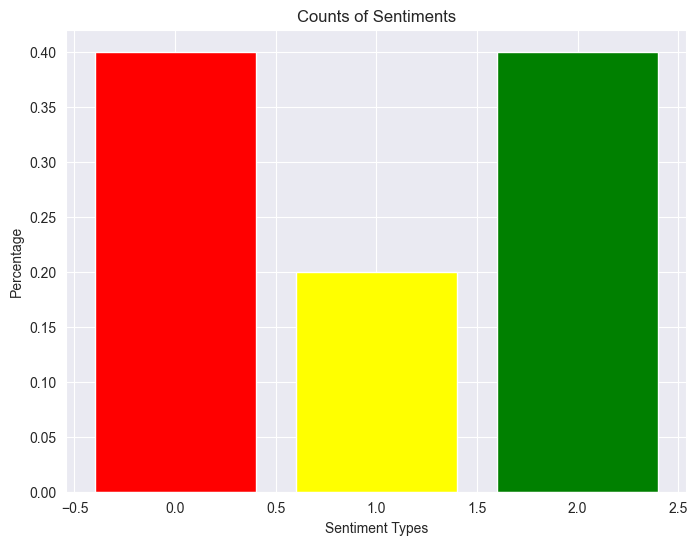

In [253]:
plot_distribution(dataset['sentiment'])

As we expected the middle category is less present. This is important during training

### Dataset selection

The dataset has too many rows, now select only 600k rows with equal sentiment distribution

In [254]:
dataset = sample_balanced(dataset, 
                          max_samples_per_class=MAX_SAMPLES_PER_CLASS, 
                          groupby_column='sentiment')
save_csv(dataset, DATASET_600K)

file overwrite


Now distributions are all equal

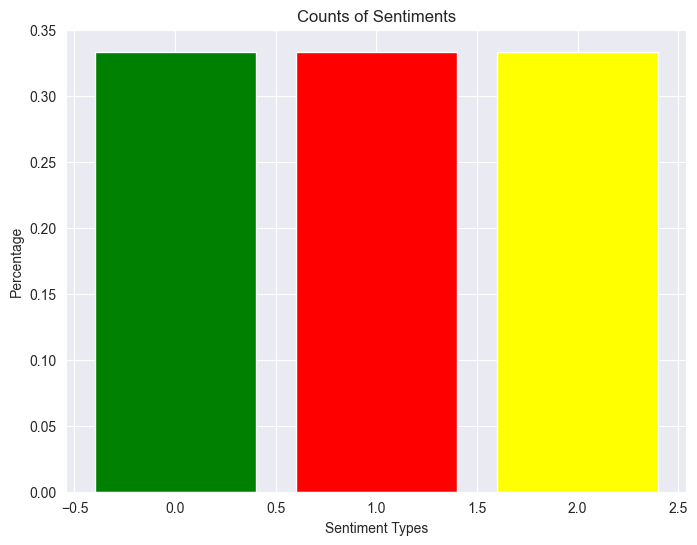

In [255]:
plot_distribution(dataset['sentiment'])

### Language cleaning

Author specifies that there are some reviews not in English. Let's use fasttext, developed by Facebook, to find the languages.

In [256]:
languages_text = compute_languages(dataset['text'])

Now check the distributions of languages

In [257]:
languages_text.value_counts()

text
__label__en    598381
__label__es      1072
__label__ja       304
__label__fr       117
__label__pt        48
__label__de        29
__label__it        23
__label__sr         5
__label__nl         4
__label__tr         3
__label__pl         2
__label__ia         2
__label__ms         2
__label__mk         1
__label__cy         1
__label__ro         1
__label__sv         1
__label__lt         1
__label__no         1
__label__da         1
__label__id         1
Name: count, dtype: int64

There are instances not in English. Remove all not English reviews in title and text

In [258]:
dataset = remove_not_modal_languages(languages_text)(dataset)
save_csv(dataset, ONLY_ENGLISH)

file overwrite


## Text preprocessing

Now we preprocessed the dataframe to be manipulated and used in deep learning methods and with LSA. The operations that are performed sequentially are:
- text to lower case
- tokenization, 
- expansion of contractions, 
- word correction, 
- stop word removal 
- punctuation removal

In [265]:
dataset['text'] = TextPreprocessor().preprocess(dataset['text'])
save_csv(dataset, PREPROCESSED_DATASET_600K)

file saved


In [21]:
# grouped = train.groupby('stars')['text'].apply(lambda x: ' '.join(x)).reset_index()
# for star_rating, reviews in zip(grouped['stars'], grouped['text']):
#   word_cloud(reviews, f'Word cloud for {star_rating} stars')
  
# Concatenate the aggregated reviews into a single string

## LSA analysis

### Words count

In [115]:
documents = dataset['text'].astype(str)
word_counts = Counter()
document_presence = Counter()

In [116]:
for document in documents:
    words = document.split()    
    word_counts.update(words)
    document_presence.update(set(words))

In [117]:
# Get the top 10 most frequent words
words_frequency = word_counts.most_common()
total_words = sum(dict(words_frequency).values())
words_frequency_percentage = {word: frequency / total_words * 100 
                              for word, frequency in dict(words_frequency).items()}
words_in_documents = document_presence.most_common()
words_in_document_percentage = {word: frequency / total_words * 100
                                for word, frequency in dict(words_in_documents).items()}
print(f'Total words in all documents: {total_words}')

Total words in all documents: 23933409


In [118]:
for word, frequency in words_frequency[:10]:
    print(f'{word} {frequency} = {words_frequency_percentage[word]:.2f}% in {dict(words_in_documents)[word]} = {words_in_document_percentage[word]:.2f}% documents')

book 332245 = 1.39% in 153859 = 0.64% documents
one 225135 = 0.94% in 166165 = 0.69% documents
good 222758 = 0.93% in 163908 = 0.68% documents
like 187986 = 0.79% in 142848 = 0.60% documents
great 169858 = 0.71% in 128528 = 0.54% documents
would 152618 = 0.64% in 123665 = 0.52% documents
get 118248 = 0.49% in 98245 = 0.41% documents
read 117619 = 0.49% in 84003 = 0.35% documents
time 107676 = 0.45% in 90171 = 0.38% documents
really 107272 = 0.45% in 86998 = 0.36% documents


In [120]:
for word, frequency in words_in_documents[:10]:
    print(f'{word} {dict(words_in_documents)[word]} = {words_in_document_percentage[word]:.2f}% documents with frequency {frequency} = {words_frequency_percentage[word]:.2f}%')

one 166165 = 0.69% documents with frequency 166165 = 0.94%
good 163908 = 0.68% documents with frequency 163908 = 0.93%
book 153859 = 0.64% documents with frequency 153859 = 1.39%
like 142848 = 0.60% documents with frequency 142848 = 0.79%
great 128528 = 0.54% documents with frequency 128528 = 0.71%
would 123665 = 0.52% documents with frequency 123665 = 0.64%
get 98245 = 0.41% documents with frequency 98245 = 0.49%
time 90171 = 0.38% documents with frequency 90171 = 0.45%
really 86998 = 0.36% documents with frequency 86998 = 0.45%
well 84980 = 0.36% documents with frequency 84980 = 0.41%


### Word embedding

In [142]:
model = Word2Vec(dataset['text'].astype(str).str.split(), 
                 vector_size=128,
                 window=10,
                 min_count=3, 
                 epochs=10)

In [145]:
for word, similarity in model.wv.most_similar(['bad'], topn=5):
    print(f'{word}: {round(similarity * 100)}%')

good: 73%
terrible: 70%
horrible: 69%
awful: 62%
lame: 58%


### Top words

In [121]:
y = dataset['sentiment']

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['text'].astype(str))

In [122]:
word_to_scores = {word: {} for word in tfidf_vectorizer.get_feature_names_out()}
for sentiment in set(y):
    chi2_stat, _ = chi2(tfidf_matrix, np.where(y == sentiment, 1, 0))
    zip_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), chi2_stat))
    for word, score in zip_scores.items():
        word_to_scores[word][sentiment] = score

In [123]:
word_to_class = {word: max(scores, key=scores.get)
                 for word, scores in word_to_scores.items()}

In [124]:
chi2_stat, _ = chi2(tfidf_matrix, y)
top_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), chi2_stat))
top_words = [word for word in sorted(top_scores, key=top_scores.get, reverse=True)]

In [125]:
top_words_by_class = {klass: [] for klass in set(y)}
top_n_words = 10
for sorted_word in top_words:
    if all([len(values) >= top_n_words for values in top_words_by_class.values()]):
        break
    if len(top_words_by_class[word_to_class[sorted_word]]) < top_n_words:
        top_words_by_class[word_to_class[sorted_word]].append(sorted_word)
pd.DataFrame(top_words_by_class)

,0,1,2
0,waste,okay,great
1,money,however,excellent
2,worst,bit,love
3,poor,decent,highly
4,terrible,ever,awesome
5,junk,overall,wonderful
6,boring,pretty,disappointed
7,horrible,interesting,perfect
8,awful,average,best
9,good,though,easy


In [130]:
only_english = load_csv(DATASET_600K)

In [140]:
texts_with_bad = search_in_text(only_english, 'bad', sentiment=2, limit=3)['text']
print_texts(texts_with_bad, highlight_texts = 'bad')

I love this camcorder I love this camcorder. I purchased it online so that I could use it to record my stand up and upload it to you tube and it has not let me down yet. The only thing bad I would say is you must keep a lot of batteries with you if you are going to use it as much as I do because you need AA batteries to power it up. But I honestly think this is the best invention ever well besides the microwave, well there's the car and the stop light and how about the ...well you get the point its a really nice camcorder and it's afforable.
--------------------------------
There's hope for humanity after all.... This is probably one of PKD's easiest reads, so save it for the day when you don't want to confront life's difficulties.... despite all the problems the characters face, there is a happy, almost upbeat, ending (well, as happy as any of his novels gets). The writing/theme/characters/etc reflect as usual his alternative approach, which may not appeal to all readers. But for me, 

## Non neural models

### Data preparation

In [146]:
X = dataset['text'].astype(str)
y = dataset['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size=0.2,  
                                                    random_state=RANDOM_STATE)

tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1, 3))
tfidf_x_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_x_test = tfidf_vectorizer.transform(x_test)

count_vectorizer = CountVectorizer(binary=True, min_df=3, max_df=0.95, ngram_range=(1, 3))
counted_x_train = count_vectorizer.fit_transform(x_train)
counted_x_test = count_vectorizer.transform(x_test)

train size: 480000, test size: 120000


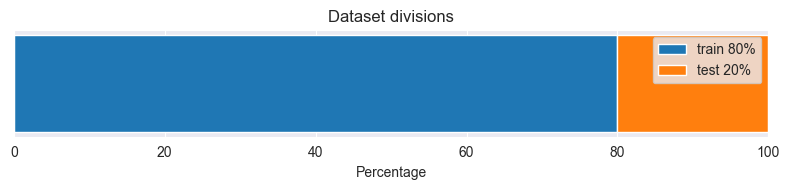

In [147]:
plot_divisions(y_train, y_test)

### Bernulli

In [226]:
model_name = 'BernulliNB'
bernulli_nb = BernoulliNB()

In [227]:
bernulli_nb = bernulli_nb.fit(counted_x_train, y_train)
save_binary_model(bernulli_nb, model_name)

resources/models/BernulliNB/BernulliNB.bin


In [228]:
train_pred_proba = bernulli_nb.predict_proba(counted_x_train)
test_pred_proba = bernulli_nb.predict_proba(counted_x_test)

In [229]:
save_model_predictions(train_pred_proba, test_pred_proba, model_name)

In [230]:
show_model_scores(train_pred_proba, y_train, test_pred_proba, y_test, model_name)

Scores for model train score is 0.84448125, test score is 0.6601


In [231]:
top_n(x_test, y_test, test_pred_proba)

nice try overall good book although book provide great storyline far many characters making difficult reader follow found constantly refer back introduction keep characters book need much editing gave book three stars overall good book sure experience author improve gift writing 
class: neutral predicted with 100.0%
lighthearted fun poor character development mary janice davidson adds another book growing collection light hearted offerings follow royal treatment book passable job character plot development though humorous moments come close capturing davidson talent writing witty funny characters betsy sinclair undead series davidson secondary romance running throughout book turns fun primary characters however two storylines one short book means gaps author ability make connections believable jumps character character said good book lazy day want enjoy light hearted romp 
class: neutral predicted with 100.0%
acceptable transfer classic fish water comedy review quality blu ray transfer

In [232]:
top_n(x_test, y_test, test_pred_proba, best=False)

still waiting amazon cancelled order ordered november february three months later still amazon pushing back delivery date item months delivery sight buying gift really really wants adores find elsewhere buy advice buy amazon update march stwell amazon cancelled order received notice would another month order fufulled needed delay given mid march consent received email amazon indicating order cancelled boo find listed anywhere else 
class: good predicted with 9.024651035331076e-20%
stopped working freezing turning try fix stopped working freezing turning try fix weeks stopped working returned replacement also stopped working weeks either turned playing song turn couple seconds turn perplexed looked amazon reviews couple reviews suggested updating firmware works perfectly thanks 
class: good predicted with 8.757384140007499e-17%
shuts battery needs replacement two years problems since powers couple network switches use usb software anything one issue one shut reason twice past two weeks 

### CatBoost

In [1]:
param_space = {
    'learning_rate': (0.01, 0.3),
    'depth': (4, 12),
    'iterations': (100, 2000),
    'l2_leaf_reg': (1, 10),
    'leaf_estimation_method': ['Newton', 'Gradient']
}

fixed_params = {
    'device_type': 'GPU',
    'loss_function': 'MultiClass', 
    'verbose': True
}


In [ ]:
best_model, best_params = bayes_grid_search(CatBoostClassifier, 
                               param_space, 
                               tfidf_x_train,
                               y_train,
                               fixed_params=fixed_params,
                               init_points=0,
                               cv = 2,
                               n_iter=1)
save_binary_model(best_model, CAT_BOOST)

|   iter    |  target   |   depth   | iterat... | l2_lea... | leaf_e... | learni... |
-------------------------------------------------------------------------------------
0:	learn: 1.0736446	total: 4.27s	remaining: 0us
0:	learn: 1.0719150	total: 5.5s	remaining: 0us
| 1         | 0.4557    | 5.532     | 1.0       | 4.94      | 0.7854    | 0.2362    |
0:	learn: 1.0676005	total: 2m 46s	remaining: 0us


In [ ]:
ping()

In [26]:
grid_search_cv(CatBoostClassifier(loss_function='MultiClass',  verbose=True), 
               param_space, 
               tfidf_x_train, 
               y_train, 
               cv=3, 
               **fit_params)

NameError: name 'fit_params' is not defined

In [13]:
# Make predictions on the TF-IDF transformed test data
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.51      0.75      0.60     39652
           1       0.29      0.28      0.29     20207
           2       0.67      0.37      0.47     40141

    accuracy                           0.50    100000
   macro avg       0.49      0.46      0.45    100000
weighted avg       0.53      0.50      0.49    100000


## Deep neural networks

### Data preparation

In [15]:
shuffled_data = dataset.sample(frac=1, random_state=RANDOM_STATE)
X = dataset['text'].astype(str)
y = to_categorical(dataset['sentiment'], num_classes=len(set(dataset['sentiment'])))

(x_train, 
 x_validation, 
 x_test, 
 y_train, 
 y_validation, 
 y_test) = split_continuously(X, y, partitions=[0.8, 0.1, 0.1])

full_x_train = pd.concat([x_train, x_validation])
full_y_train = np.vstack([y_train, y_validation])
mlen = int(max(x_train.str.len()))

train size: 480000, test size: 60000, validation size: 60000


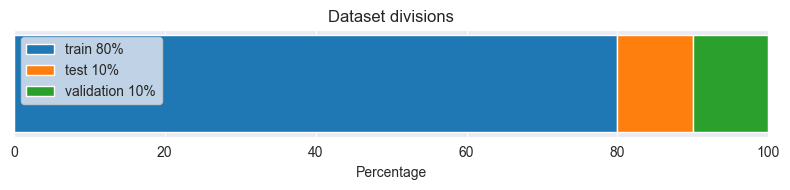

In [42]:
plot_divisions(y_train, y_test, y_validation)

In [18]:
vectorize_layer = TextVectorization(standardize=None,    
                                    max_tokens=MAX_TOKENS,
                                    ngrams=(1,2),
                                    output_sequence_length=mlen)
vectorize_layer.adapt(x_train)

### Training parameters

In [44]:
def callbacks(model_name: str):
    return [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'{MODELS_FOLDER}/{model_name}/{model_name}', 
                        monitor='val_accuracy', 
                        save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)
    ]

### 1D CNN

In [24]:
model_name = 'CNN'
model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 64),
    
    layers.Conv1D(64, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(3),
    
    layers.Conv1D(64, 5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(5),
    
    layers.Conv1D(64, 5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalMaxPooling1D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
])

In [25]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=DEFAULT_EPOCHS,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

Epoch 1/7
   7/3750 [..............................] - ETA: 6:11:09 - loss: 2.4294 - accuracy: 0.3929

KeyboardInterrupt: 

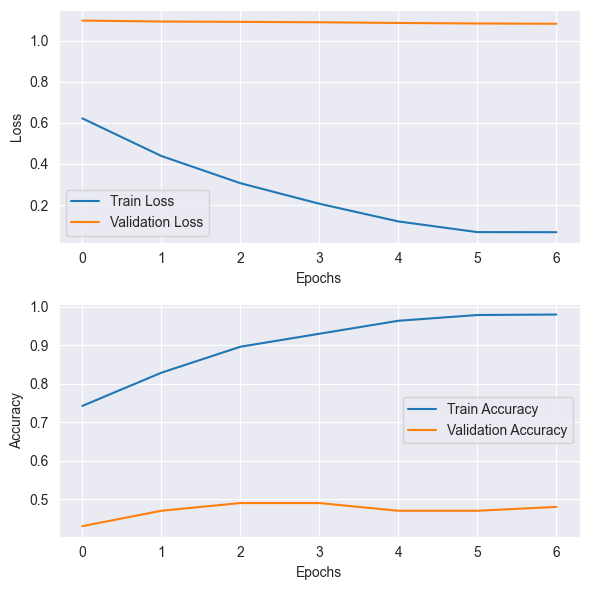

In [56]:
plot_history(history)

In [60]:
train_predictions = model.predict(full_x_train)
test_predictions = model.predict(x_test)
save_model_predictions(train_predictions, test_predictions, model_name)

4/4 [==============================] - 0s 48ms/step


Scores for model train score is 0.4033333333333333, test score is 0.26


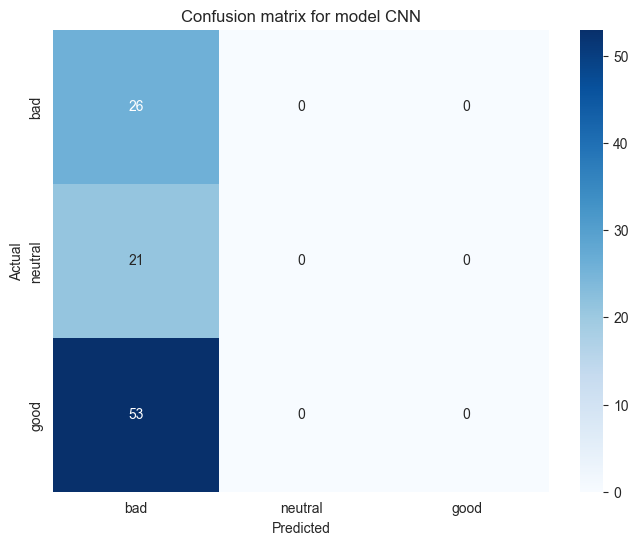

In [81]:
show_model_scores(train_predictions, full_y_train.argmax(axis=1),
                  test_predictions, y_test.argmax(axis=1),
                  model_name)

### GRU

In [82]:
model_name = 'GRU'
model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 64),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2)
])


In [84]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=DEFAULT_EPOCHS,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 1.0770 - accuracy: 0.3487INFO:tensorflow:Assets written to: resources/models\model_name\assets


INFO:tensorflow:Assets written to: resources/models\model_name\assets


7/7 [==============================] - 48s 7s/step - loss: 1.0770 - accuracy: 0.3487 - val_loss: 1.0622 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.3862INFO:tensorflow:Assets written to: resources/models\model_name\assets


INFO:tensorflow:Assets written to: resources/models\model_name\assets


7/7 [==============================] - 46s 7s/step - loss: 1.0754 - accuracy: 0.3862 - val_loss: 1.0669 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 45s 6s/step - loss: 1.0767 - accuracy: 0.3800 - val_loss: 1.0653 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 43s 6s/step - loss: 1.0752 - accuracy: 0.3862 - val_loss: 1.0676 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 46s 6s/step - loss: 1.0761 - accuracy: 0.3862 - val_loss: 1.0728 - val_accuracy: 0.3100 - lr: 0.0010


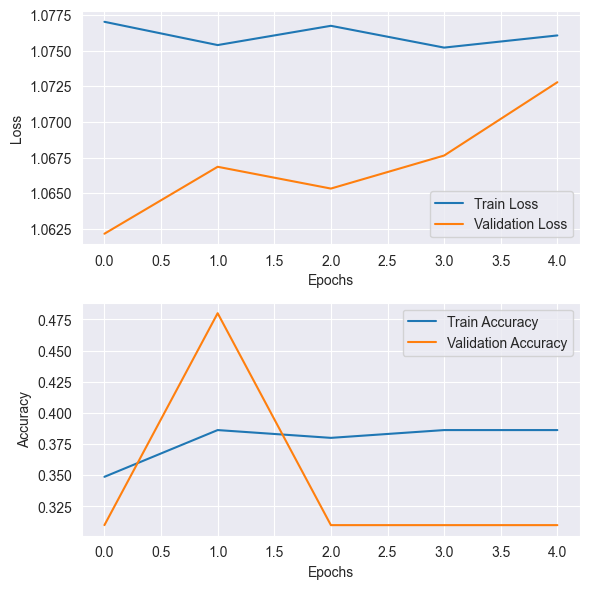

In [85]:
plot_history(history)

In [86]:
train_predictions = model.predict(full_x_train)
test_predictions = model.predict(x_test)

save_model_predictions(train_predictions, test_predictions, model_name)

4/4 [==============================] - 1s 198ms/step


Scores for model train score is 0.37777777777777777, test score is 0.53


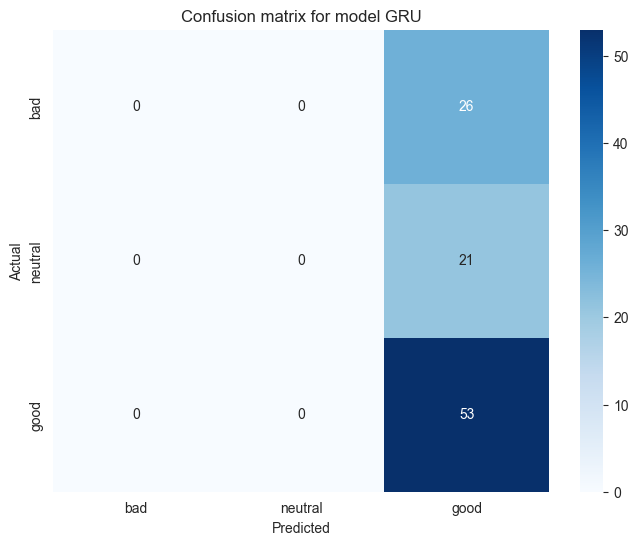

In [87]:
show_model_scores(train_predictions, np.argmax(full_y_train, axis=1),
                  test_predictions, np.argmax(y_test, axis=1),
                  model_name)

### LSTM

In [89]:
model_name = 'LSTM'
model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 64),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2)
])

In [90]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=DEFAULT_EPOCHS,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.3675INFO:tensorflow:Assets written to: resources/models\LSTM\assets


INFO:tensorflow:Assets written to: resources/models\LSTM\assets


7/7 [==============================] - 59s 7s/step - loss: 1.0876 - accuracy: 0.3675 - val_loss: 1.0534 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - 53s 7s/step - loss: 1.0771 - accuracy: 0.3750 - val_loss: 1.0786 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 51s 7s/step - loss: 1.0772 - accuracy: 0.3862 - val_loss: 1.0600 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 51s 7s/step - loss: 1.0761 - accuracy: 0.3800 - val_loss: 1.0642 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 51s 7s/step - loss: 1.0766 - accuracy: 0.3837 - val_loss: 1.0701 - val_accuracy: 0.3100 - lr: 0.0010


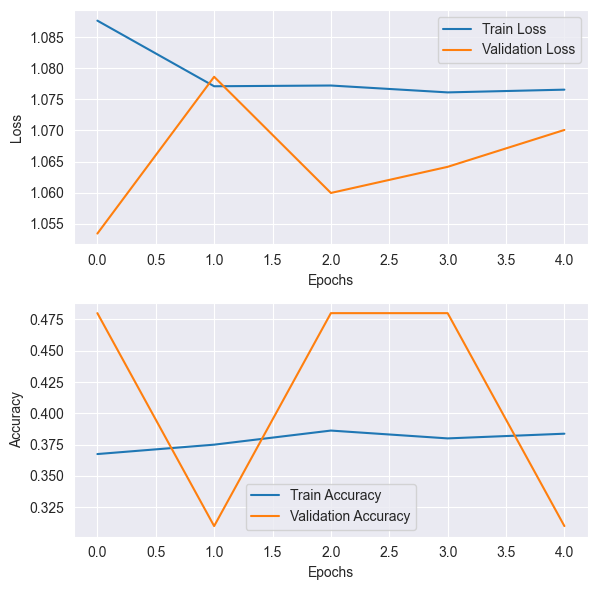

In [91]:
plot_history(history)

In [92]:
train_predictions = model.predict(full_x_train)
test_predictions = model.predict(x_test)

save_model_predictions(train_predictions, test_predictions, model_name)

4/4 [==============================] - 1s 272ms/step


Scores for model train score is 0.37777777777777777, test score is 0.53


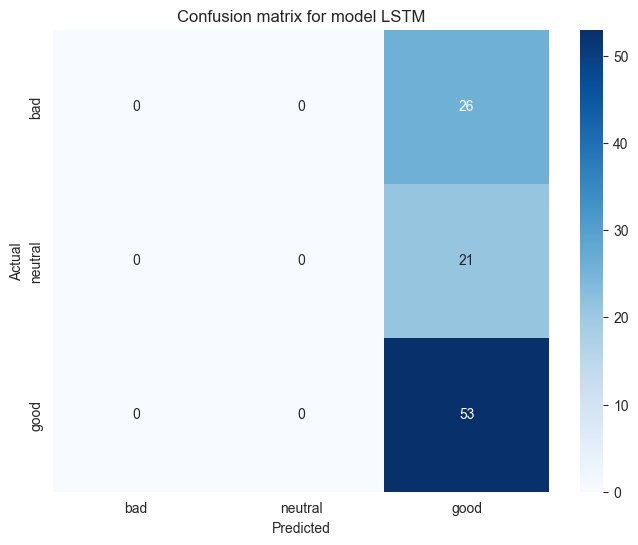

In [93]:
show_model_scores(train_predictions, full_y_train.argmax(axis=1),
                  test_predictions, y_test.argmax(axis=1),
                  model_name)

### Bidirectinal LSTM

In [42]:
model_name = 'Bidirectional_LSTM'
model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 64),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2)
])

"\nlayers.Bidirectional(layers.LSTM(64, return_sequences=True)),\nlayers.Bidirectional(layers.LSTM(32, return_sequences=True)),\nlayers.Bidirectional(layers.LSTM(16)),\nlayers.Dense(128, activation='relu'),\nlayers.Dropout(0.2)\n"

In [43]:
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=DEFAULT_EPOCHS,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

Epoch 1/100


ValueError: in user code:

    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (128, 3) and (None, 851, 3) are incompatible


In [ ]:
plot_history(history)

In [ ]:
train_predictions = model.predict(full_x_train)
test_predictions = model.predict(x_test)

save_model_predictions(train_predictions, test_predictions, model_name)

In [ ]:
show_model_scores(train_predictions, full_y_train.argmax(axis=1),
                  test_predictions, y_test.argmax(axis=1),
                  model_name)

## Pre-trained models

### Universal sentence encoder

In [26]:
import tensorflow_hub as hub

import os
os.environ['TFHUB_CACHE_DIR'] = BINARY_DATA
model = build_nn_model([
    hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                   trainable=True, 
                   dtype=tf.string, 
                   input_shape=[]),
    layers.Reshape((512, 1)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D()
])

In [ ]:
model_name = 'USE'
history = model.fit(x_train, 
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=7,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

### Using GloVe embeddings

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X = dataset['text'].astype(str)
labels = to_categorical(dataset['sentiment'], num_classes=len(set(dataset['sentiment'])))

In [16]:
tokenizer = Tokenizer(nb_words=MAX_TOKENS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

mlen = int(max(X.str.len()))
data = pad_sequences(sequences, maxlen=mlen, padding='post')

labels = to_categorical(dataset['sentiment'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.1 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Found 294798 unique tokens.
Shape of data tensor: (600000, 851)
Shape of label tensor: (600000, 3)


In [17]:
glove_embeddings = load_glove_embedding('resources/glove.6B.300d.txt')

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
model = Sequential([
        #layers.Input(shape=(mlen,), dtype='int32'),
        layers.Embedding(len(word_index) + 1,
                                300,
                                weights=[embedding_matrix],
                                input_length=mlen,
                                trainable=False),
        layers.GRU(128,return_sequences=True),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2


ValueError: in user code:

    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Gardo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 851, 3) are incompatible


In [22]:
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Sample text data
texts = [
    "This is the first sentence.",
    "Here is the second sentence.",
    "And this is the third sentence."
]

# Initialize and fit the Tokenizer
tokenizer = Tokenizer(nb_words=MAX_TOKENS)
tokenizer.fit_on_texts(X)

labels = to_categorical(dataset['sentiment'], num_classes=3)
# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(X)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Define a simple GRU-based model
model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length),
    keras.layers.GRU(64),
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy labels for binary classification (change as needed)

# Train the model (change as needed)
model.fit(padded_sequences, labels, epochs=10, batch_size=1)

# Now, you can use the trained model for prediction by converting new text data to sequences and padding it similarly to 'padded_sequences'.


Epoch 1/10
  1570/600000 [..............................] - ETA: 59:17:50 - loss: 1.1036 - accuracy: 0.3223


KeyboardInterrupt



### Transformers

In [17]:
from transformers import AutoTokenizer,TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=BINARY_DATA)
bert = TFBertModel.from_pretrained('bert-base-cased', cache_dir=BINARY_DATA)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [68]:
type(tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [26]:
tokenized_x_train = tokenizer(
    text=x_train.tolist()[:500],
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False)

tokenized_x_validation = tokenizer(
    text=x_validation.tolist()[:500],
    add_special_tokens=True,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False)

In [25]:
tokenized_x_train


{'input_ids': <tf.Tensor: shape=(500, 132), dtype=int32, numpy=
array([[  101,  7805,  1469, ...,     0,     0,     0],
       [  101,  4736,   188, ...,     0,     0,     0],
       [  101,  1221, 13980, ...,     0,     0,     0],
       ...,
       [  101,  6782, 10866, ...,     0,     0,     0],
       [  101,  3427, 11019, ...,     0,     0,     0],
       [  101,  4417,  1189, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(500, 132), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [93]:
tokenized_x_validation

{'input_ids': <tf.Tensor: shape=(500, 100), dtype=int32, numpy=
array([[  101,  1759,  1329, ...,     0,     0,     0],
       [  101,  5250,  1403, ...,     0,     0,     0],
       [  101,  3851,  1148, ...,     0,     0,     0],
       ...,
       [  101,  6782, 24266, ...,     0,     0,     0],
       [  101,  1759,  1218, ...,     0,     0,     0],
       [  101,  1363,  1642, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(500, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [33]:
from keras.optimizers import AdamW

def BERT_model():
    input_ids = layers.Input(shape=(200,), dtype=tf.int32, name="input_ids")
    input_mask = layers.Input(shape=(200,), dtype=tf.int32, name="attention_mask")
    pooled_output = bert(input_ids, attention_mask=input_mask).pooler_output
    out = layers.Dense(128, activation='relu')(pooled_output)
    out = layers.Dropout(0.2)(out)
    out = layers.Dense(32, activation='relu')(out)
    out = layers.Dropout(0.2)(out)
    y = layers.Dense(3, activation='softmax')(out)
    model = keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    model.compile(optimizer=AdamW(learning_rate=5e-05), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = BERT_model()

In [ ]:
history = model.fit(x = {'input_ids': tokenized_x_train['input_ids'],
                         'attention_mask': tokenized_x_train['attention_mask']},
                    y = y_train[:500],
                    validation_data = ({'input_ids':tokenized_x_validation['input_ids'],
                                        'attention_mask': tokenized_x_validation['attention_mask']}, 
                                       y_validation[:500]),
                    epochs=1,
                    batch_size=36,
                    verbose=True,
                    callbacks=callbacks('BERT')
)

 3/14 [=====>........................] - ETA: 29:42 - loss: 0.1379 - accuracy: 0.9537

## Failures

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['text'])

In [ ]:
n_components = 200
U, Sigma, VT = randomized_svd(tfidf_matrix, n_components=n_components, random_state=RANDOM_STATE)
terms_lsa =  VT.T @ diag(Sigma)
documents_lsa = U @ diag(Sigma)

### SVD analysis

In [106]:
print(f'U shape: {U.shape}')
print(f'Sigma {Sigma.shape}')
print(f'V transposed {VT.shape}')

U shape: (600000, 200)
Sigma (200,)
V transposed (200, 294420)


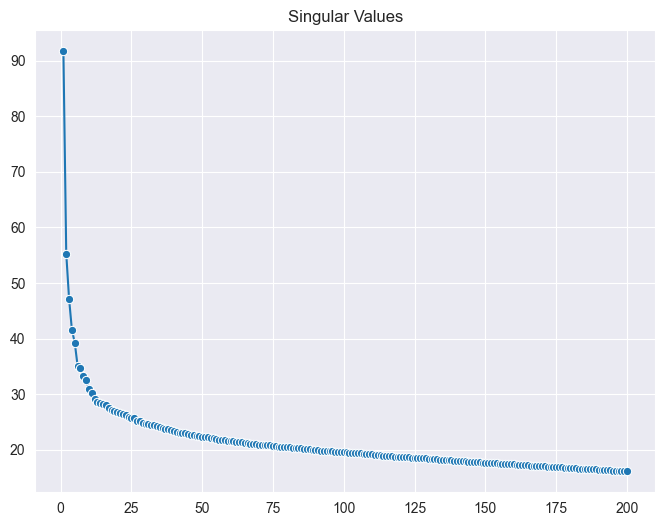

In [107]:
plot_singular_values(Sigma)

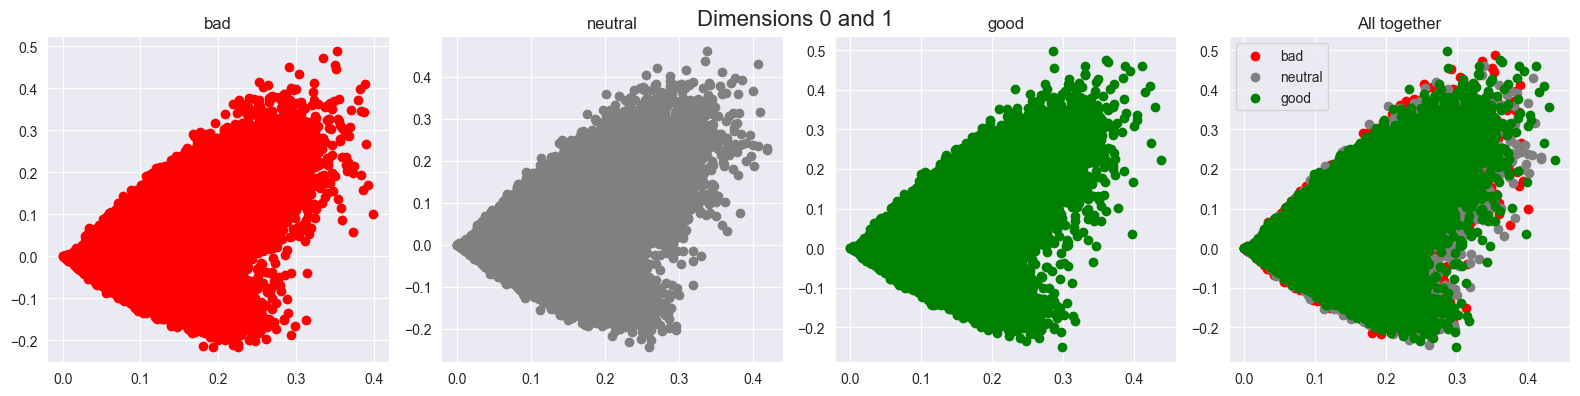

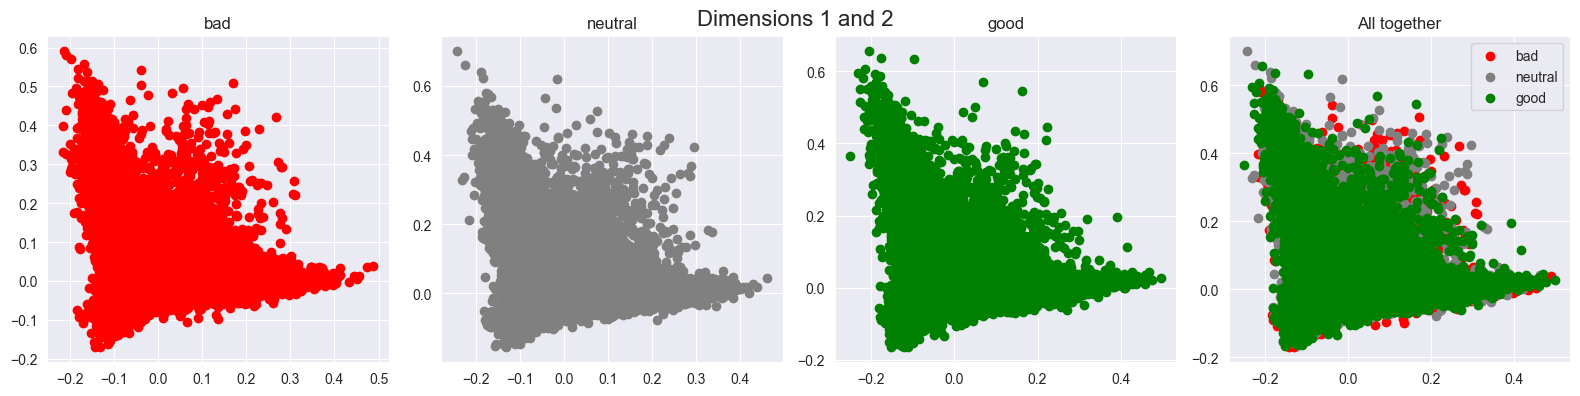

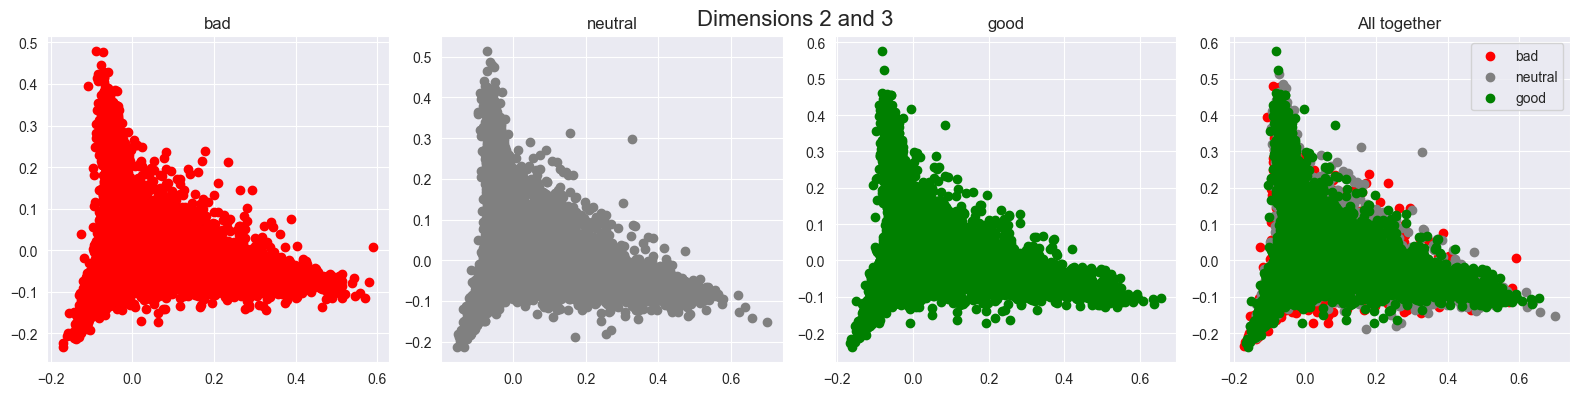

In [114]:
categories = dataset['sentiment'].values

# Define a color mapping for categories
color_mapping = {
    0: 'red',
    1: 'gray',
    2: 'green',
}

sentiment_mapping = {
    0: 'bad',
    1: 'neutral',
    2: 'good',
}

# Create a scatter plot for each category
for i in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i+1]
        
        ax = axes[j]
        ax.scatter(x, y, c=color, label='Scatter 1')
        ax.set_title(sentiment_mapping[category])
        # Adjust layout to prevent overlap
        plt.tight_layout()
    
    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i+1]
        
        scatter = axes[3].scatter(documents_lsa[categories == category, i], 
                                  documents_lsa[categories == category, i+1], 
                                  c=color_mapping[category],
                                  label=f'{sentiment_mapping[category]}')
    axes[3].legend()
    axes[3].set_title("All together")
        # Adjust layout to prevent overlap
    
    plt.suptitle(f'Dimensions {i} and {i+1}', fontsize=16)
    # Show the plot
    plt.show()

### SVD for words similarity

In [98]:
weighted_word_encoding = (np.diag(Sigma) @ VT).T

In [103]:
def compute_similarity(word, weighted_word_encoding, vocabulary, words_to_index, top_n=5):
    target_word_index = words_to_index[word]
    target_word_vector = weighted_word_encoding[target_word_index].reshape(1, -1)
    cosine_similarities = cosine_similarity(target_word_vector, weighted_word_encoding)[0]
    most_similar_words = np.argsort(cosine_similarities)[::-1][1:top_n]
   
    print(f"For word: {word}")
    print(f'Top {top_n} most correlated words are')
    for idx in most_similar_words:
        print(f"{vocabulary[idx]}: {cosine_similarities[idx]:.2f}")

In [104]:
compute_similarity('good', 
                   weighted_word_encoding, 
                   tfidf_vectorizer.get_feature_names_out(),
                   tfidf_vectorizer.vocabulary_)


For word: good
Top 5 most correlated words are
ogooosd: 0.87
ogoodvo: 0.87
ogggdd: 0.87
oggod: 0.87
